Task 3 — Unsupervised Learning 

In [ ]:
# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 1. LOAD DATA
# ============================================================================
print("="*80)
print("WIND TURBINE ANOMALY DETECTION")
print("="*80)

df = pd.read_csv("dataset\\T1_cleaned.csv")
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values('Date/Time').reset_index(drop=True)

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['Date/Time'].min()} to {df['Date/Time'].max()}")

WIND TURBINE ANOMALY DETECTION
Dataset loaded: (37803, 5)
Date range: 2018-01-01 00:00:00 to 2018-12-31 23:50:00


In [2]:
# 2. POWER CURVE DEVIATION ANALYSIS (Domain-Specific)
# ============================================================================
print("\n" + "="*80)
print("POWER CURVE DEVIATION ANALYSIS")
print("="*80)

# Calculate performance ratio and deviation
df['Performance_Ratio'] = (df['LV ActivePower (kW)'] / 
                           (df['Theoretical_Power_Curve (KWh)'] + 1e-6))

df['Power_Deviation'] = ((df['LV ActivePower (kW)'] - 
                          df['Theoretical_Power_Curve (KWh)']) / 
                         (df['Theoretical_Power_Curve (KWh)'] + 1e-6)) * 100

# Define underperformance based on industry standards
# Typically, <80% of theoretical is considered underperformance
UNDERPERFORMANCE_THRESHOLD = 0.80  # 80%
SEVERE_UNDERPERFORMANCE = 0.60     # 60%

df['Underperformance_Flag'] = df['Performance_Ratio'] < UNDERPERFORMANCE_THRESHOLD
df['Severe_Underperformance'] = df['Performance_Ratio'] < SEVERE_UNDERPERFORMANCE

# Statistics
total_records = len(df)
underperforming = df['Underperformance_Flag'].sum()
severe_underperforming = df['Severe_Underperformance'].sum()

print(f"\nPerformance Statistics:")
print(f"  Total Records: {total_records:,}")
print(f"  Underperforming (<80%): {underperforming:,} ({underperforming/total_records*100:.2f}%)")
print(f"  Severe Underperformance (<60%): {severe_underperforming:,} ({severe_underperforming/total_records*100:.2f}%)")
print(f"\nPerformance Ratio Statistics:")
print(f"  Mean: {df['Performance_Ratio'].mean():.4f}")
print(f"  Median: {df['Performance_Ratio'].median():.4f}")
print(f"  Std Dev: {df['Performance_Ratio'].std():.4f}")
print(f"  Min: {df['Performance_Ratio'].min():.4f}")
print(f"  Max: {df['Performance_Ratio'].max():.4f}")

# ============================================================================
# 3. ISOLATION FOREST ANOMALY DETECTION
# ============================================================================
print("\n" + "="*80)
print("ISOLATION FOREST ANOMALY DETECTION")
print("="*80)

# Prepare features for anomaly detection
features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 
            'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

X = df[features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
# contamination: expected proportion of anomalies (typically 0.01-0.1)
print("\nTraining Isolation Forest...")
iso_forest = IsolationForest(
    contamination=0.05,  # Expect ~5% anomalies
    random_state=42,
    n_estimators=100,
    max_samples='auto',
    verbose=0
)

# Predict anomalies (-1 for anomalies, 1 for normal)
df['Anomaly_IsolationForest'] = iso_forest.fit_predict(X_scaled)
df['Anomaly_Score'] = iso_forest.score_samples(X_scaled)

# Convert to binary (1 for anomaly, 0 for normal)
df['Is_Anomaly_IF'] = (df['Anomaly_IsolationForest'] == -1).astype(int)

anomalies_if = df['Is_Anomaly_IF'].sum()
print(f"\nIsolation Forest Results:")
print(f"  Anomalies Detected: {anomalies_if:,} ({anomalies_if/total_records*100:.2f}%)")
print(f"  Normal Points: {total_records - anomalies_if:,}")

# ============================================================================
# 4. COMBINED ANOMALY DETECTION
# ============================================================================
print("\n" + "="*80)
print("COMBINED ANOMALY DETECTION")
print("="*80)

# Combine both methods: Point is anomaly if EITHER method flags it
df['Combined_Anomaly'] = ((df['Is_Anomaly_IF'] == 1) | 
                          (df['Underperformance_Flag'] == True)).astype(int)

# Create severity levels
df['Anomaly_Severity'] = 'Normal'
df.loc[df['Underperformance_Flag'], 'Anomaly_Severity'] = 'Moderate'
df.loc[df['Severe_Underperformance'], 'Anomaly_Severity'] = 'Severe'
df.loc[df['Is_Anomaly_IF'] == 1, 'Anomaly_Severity'] = 'Critical'

# Statistics
combined_anomalies = df['Combined_Anomaly'].sum()
print(f"\nCombined Anomaly Detection Results:")
print(f"  Total Anomalies: {combined_anomalies:,} ({combined_anomalies/total_records*100:.2f}%)")
print(f"\nAnomaly Breakdown by Severity:")
severity_counts = df['Anomaly_Severity'].value_counts()
for severity, count in severity_counts.items():
    print(f"  {severity}: {count:,} ({count/total_records*100:.2f}%)")

# Detailed breakdown
print(f"\nDetailed Analysis:")
print(f"  Isolation Forest Only: {(df['Is_Anomaly_IF'] == 1).sum():,}")
print(f"  Underperformance Only: {df['Underperformance_Flag'].sum():,}")
print(f"  Both Methods: {((df['Is_Anomaly_IF'] == 1) & df['Underperformance_Flag']).sum():,}")

# ============================================================================
# 5. ANALYZE ANOMALY CHARACTERISTICS
# ============================================================================
print("\n" + "="*80)
print("ANOMALY CHARACTERISTICS ANALYSIS")
print("="*80)

# Compare normal vs anomalous data
normal_data = df[df['Combined_Anomaly'] == 0]
anomaly_data = df[df['Combined_Anomaly'] == 1]

print("\nComparison: Normal vs Anomalous Data")
print("-"*80)
print(f"{'Metric':<30} {'Normal':<20} {'Anomalous':<20}")
print("-"*80)

for col in features:
    normal_mean = normal_data[col].mean()
    anomaly_mean = anomaly_data[col].mean()
    print(f"{col:<30} {normal_mean:<20.2f} {anomaly_mean:<20.2f}")

print("-"*80)
print(f"{'Performance Ratio':<30} {normal_data['Performance_Ratio'].mean():<20.4f} {anomaly_data['Performance_Ratio'].mean():<20.4f}")



POWER CURVE DEVIATION ANALYSIS

Performance Statistics:
  Total Records: 37,803
  Underperforming (<80%): 5,563 (14.72%)
  Severe Underperformance (<60%): 689 (1.82%)

Performance Ratio Statistics:
  Mean: 34083.2023
  Median: 0.9123
  Std Dev: 1049086.6362
  Min: 0.1349
  Max: 56388351.4404

ISOLATION FOREST ANOMALY DETECTION

Training Isolation Forest...

Isolation Forest Results:
  Anomalies Detected: 1,891 (5.00%)
  Normal Points: 35,912

COMBINED ANOMALY DETECTION

Combined Anomaly Detection Results:
  Total Anomalies: 7,038 (18.62%)

Anomaly Breakdown by Severity:
  Normal: 30,765 (81.38%)
  Moderate: 4,589 (12.14%)
  Critical: 1,891 (5.00%)
  Severe: 558 (1.48%)

Detailed Analysis:
  Isolation Forest Only: 1,891
  Underperformance Only: 5,563
  Both Methods: 416

ANOMALY CHARACTERISTICS ANALYSIS

Comparison: Normal vs Anomalous Data
--------------------------------------------------------------------------------
Metric                         Normal               Anomalous     


GENERATING VISUALIZATIONS
✓ Saved: task3_timeseries_anomalies.png


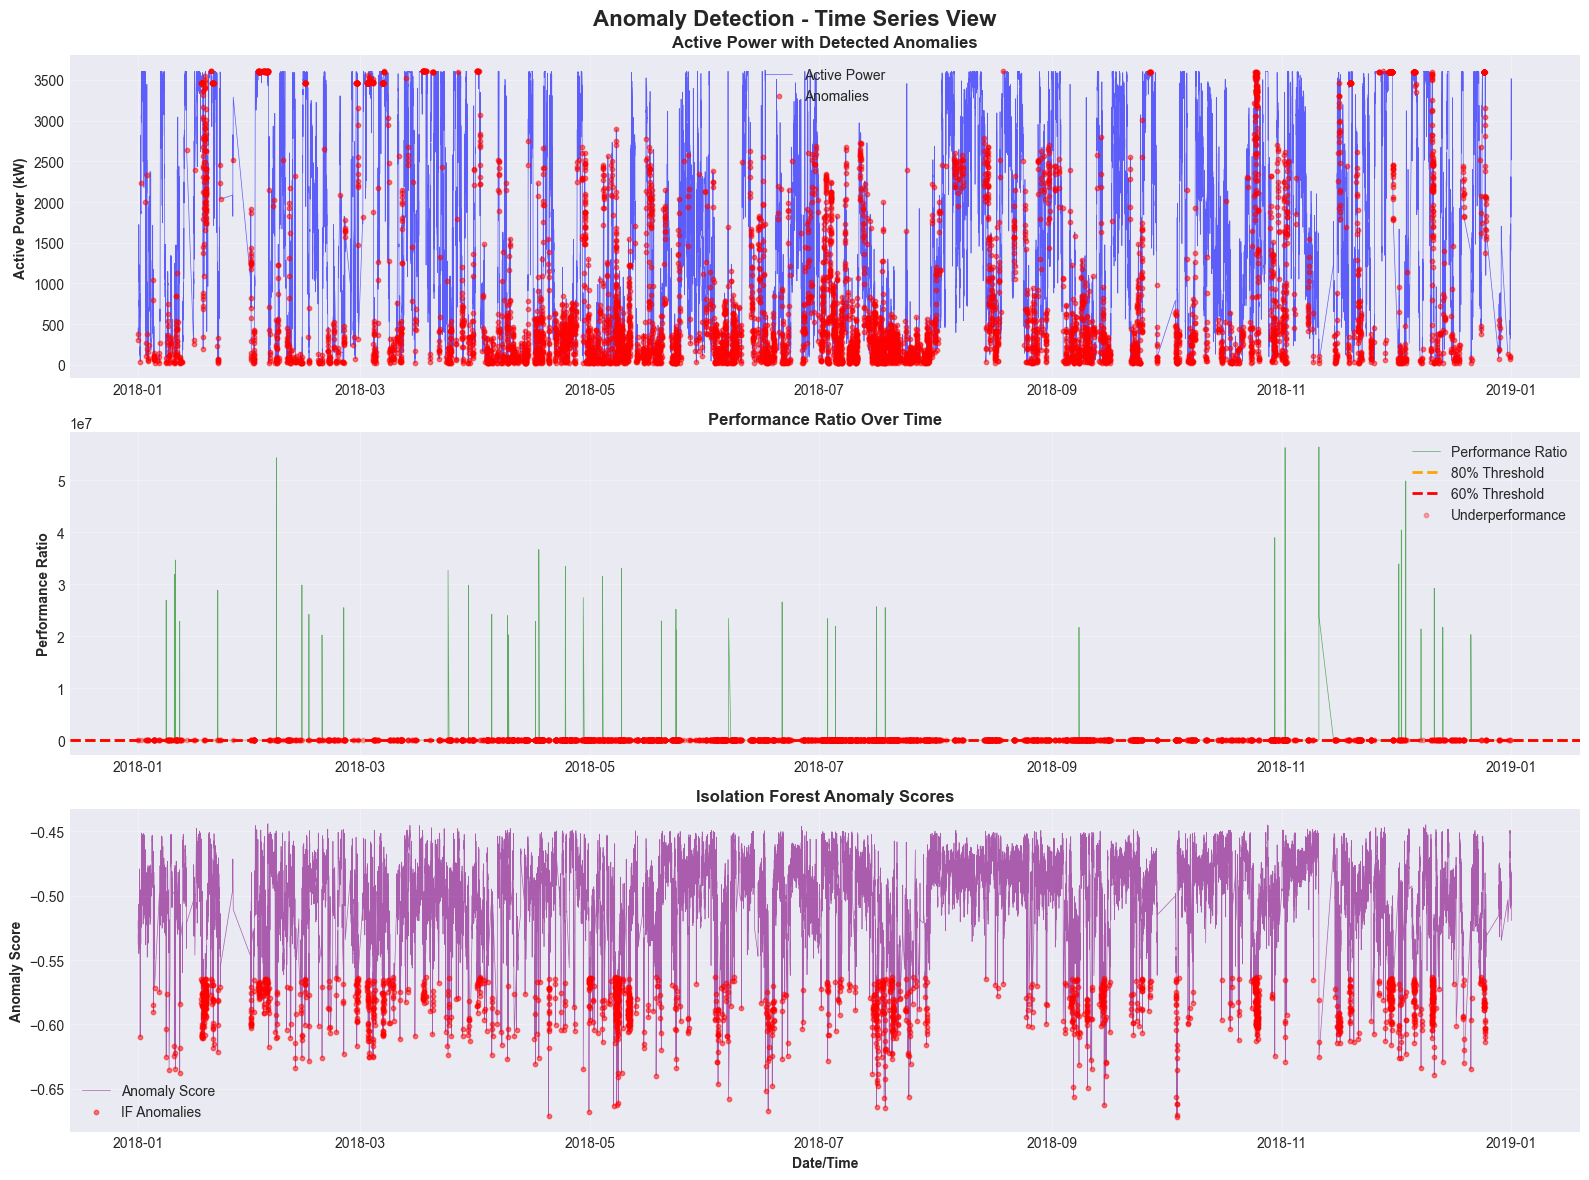

✓ Saved: task3_power_curve_anomalies.png


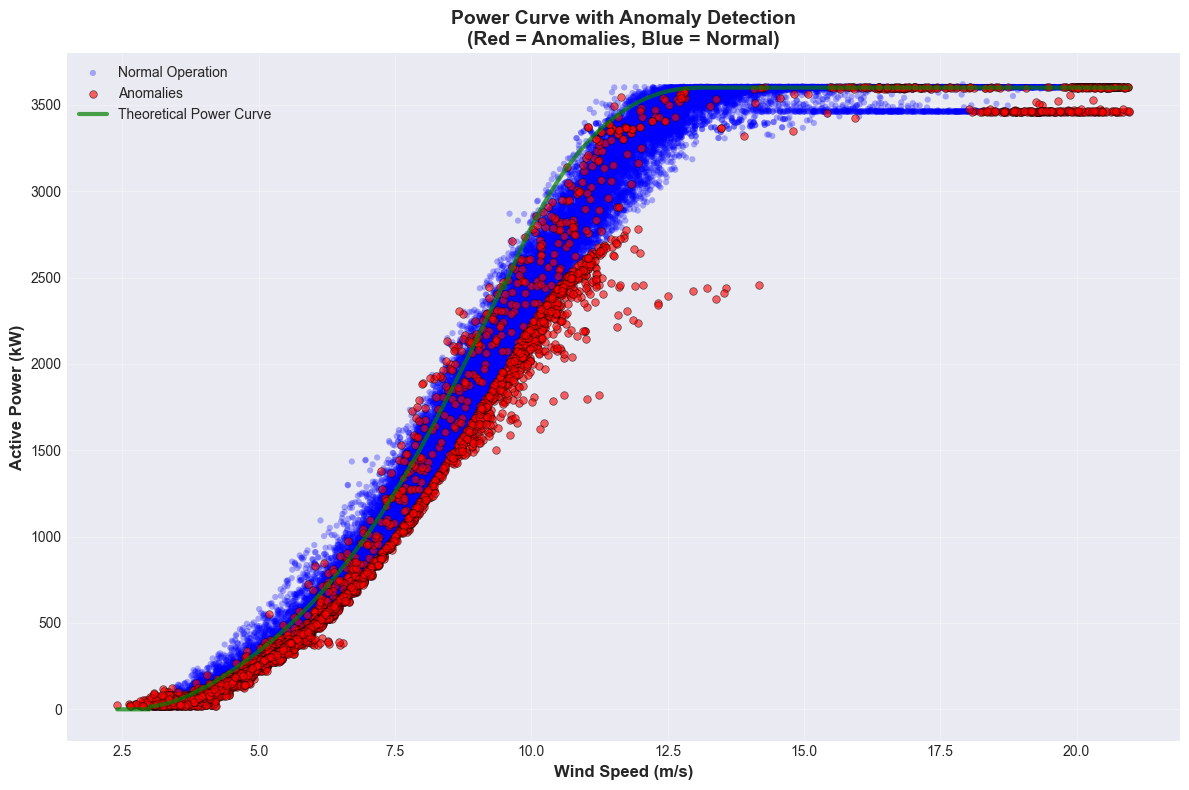

✓ Saved: task3_distribution_comparison.png


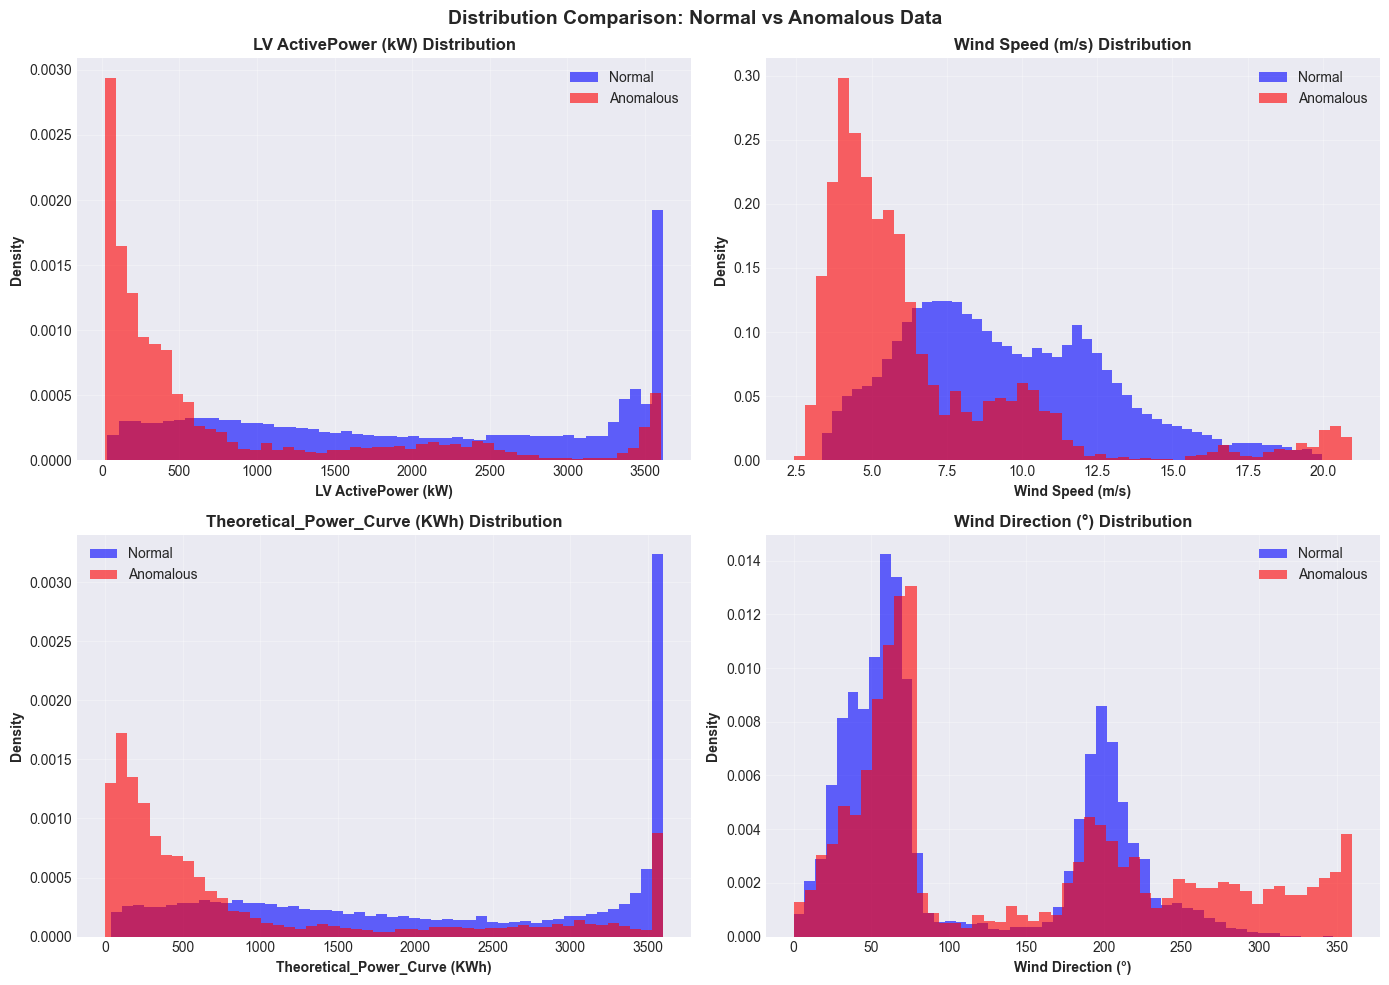

✓ Saved: task3_severity_heatmap.png


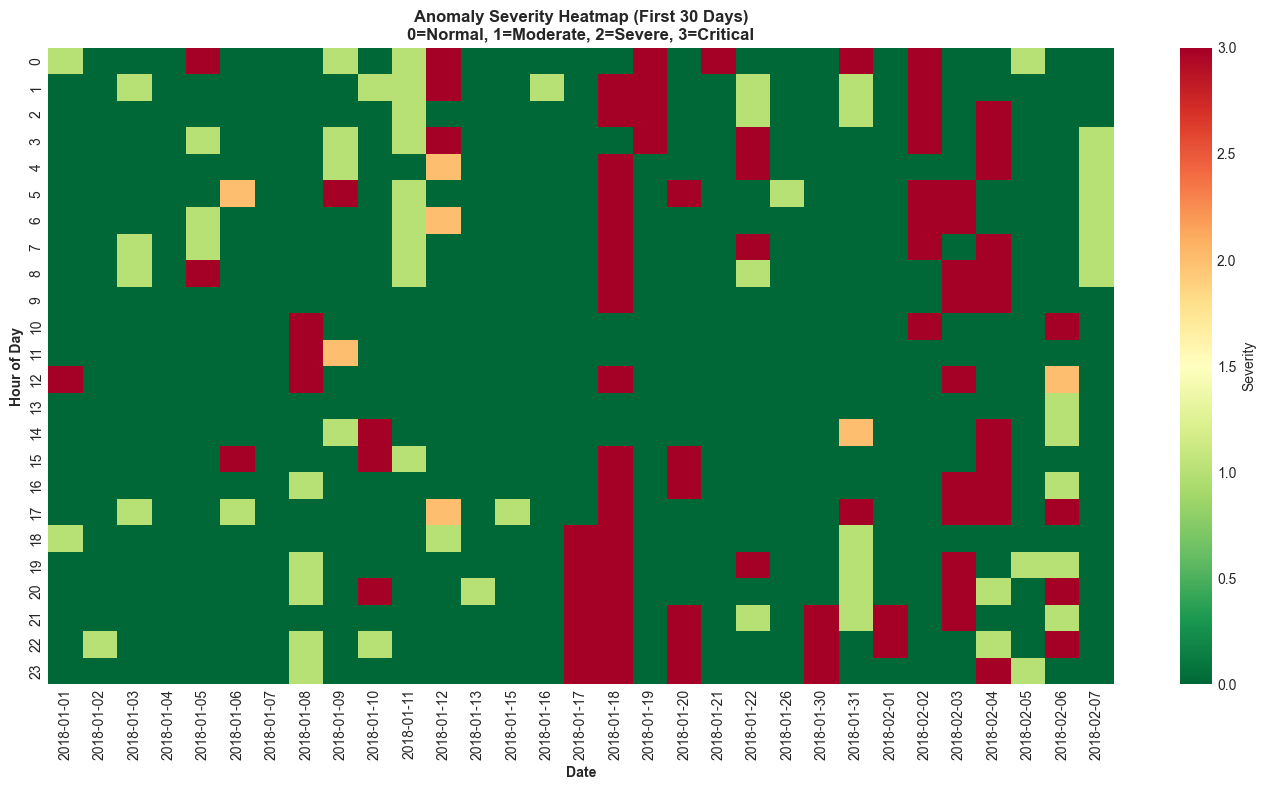

✓ Saved: task3_boxplot_comparison.png


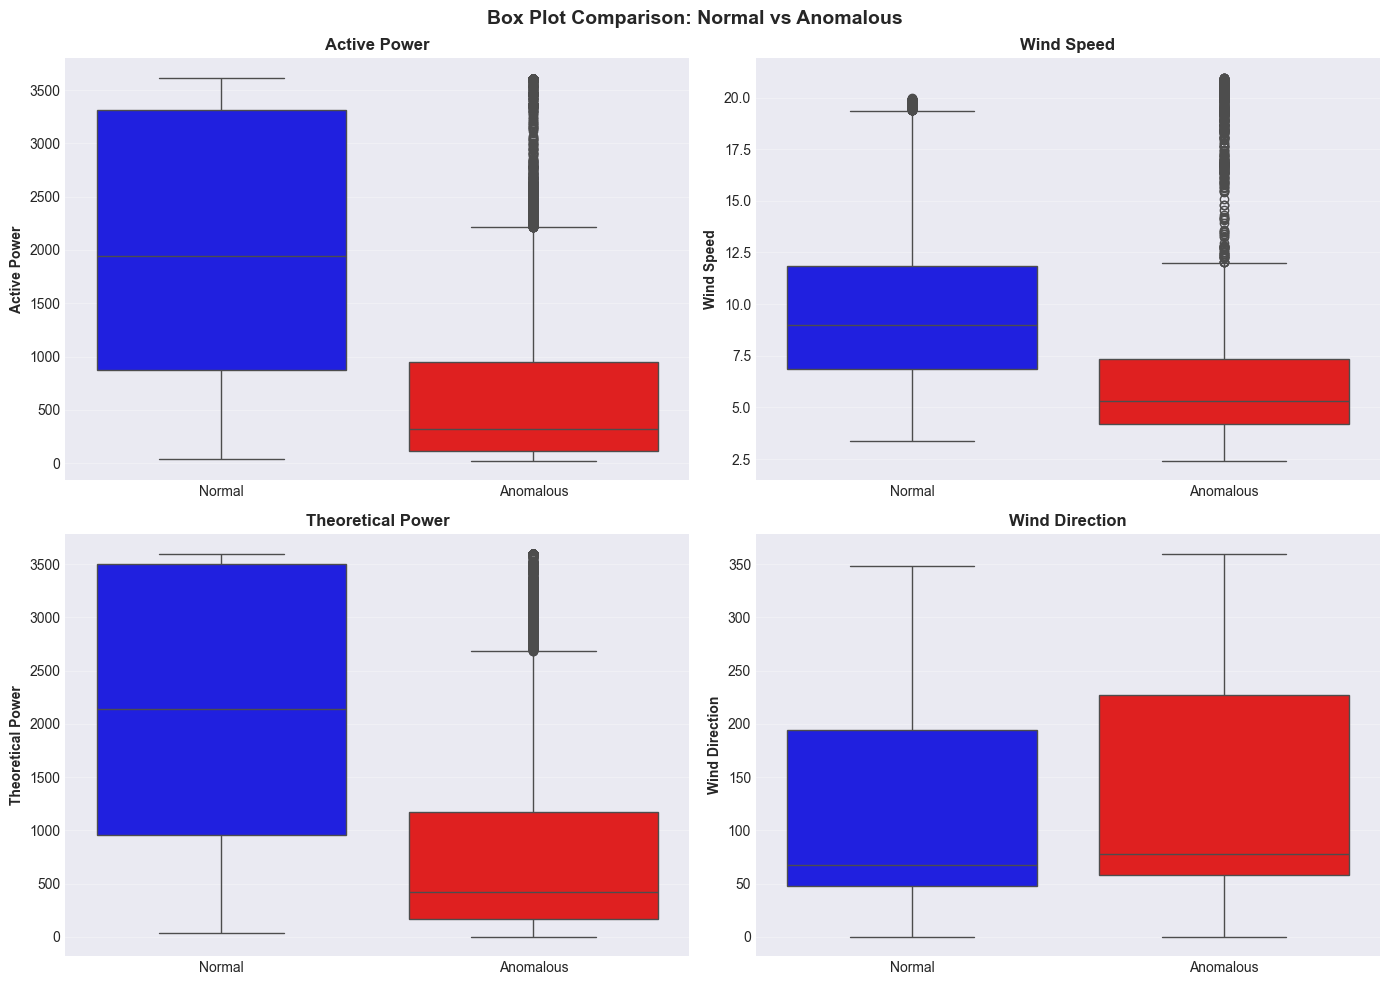


EXPORTING RESULTS
✓ Saved: task3_detected_anomalies.csv (7038 anomalies)
✓ Saved: task3_anomaly_summary.csv


In [ ]:
# 6. VISUALIZATIONS
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# 1. Time Series with Anomalies
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Anomaly Detection - Time Series View', fontsize=16, fontweight='bold')

# Plot 1: Active Power with anomalies
axes[0].plot(df['Date/Time'], df['LV ActivePower (kW)'], 
             color='blue', alpha=0.6, linewidth=0.5, label='Active Power')
anomaly_points = df[df['Combined_Anomaly'] == 1]
axes[0].scatter(anomaly_points['Date/Time'], anomaly_points['LV ActivePower (kW)'],
                color='red', s=10, alpha=0.5, label='Anomalies', zorder=5)
axes[0].set_ylabel('Active Power (kW)', fontweight='bold')
axes[0].set_title('Active Power with Detected Anomalies', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Performance Ratio
axes[1].plot(df['Date/Time'], df['Performance_Ratio'], 
             color='green', alpha=0.6, linewidth=0.5, label='Performance Ratio')
axes[1].axhline(y=UNDERPERFORMANCE_THRESHOLD, color='orange', 
                linestyle='--', linewidth=2, label='80% Threshold')
axes[1].axhline(y=SEVERE_UNDERPERFORMANCE, color='red', 
                linestyle='--', linewidth=2, label='60% Threshold')
underperf_points = df[df['Underperformance_Flag']]
axes[1].scatter(underperf_points['Date/Time'], underperf_points['Performance_Ratio'],
                color='red', s=10, alpha=0.3, label='Underperformance', zorder=5)
axes[1].set_ylabel('Performance Ratio', fontweight='bold')
axes[1].set_title('Performance Ratio Over Time', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Anomaly Score from Isolation Forest
axes[2].plot(df['Date/Time'], df['Anomaly_Score'], 
             color='purple', alpha=0.6, linewidth=0.5, label='Anomaly Score')
if_anomalies = df[df['Is_Anomaly_IF'] == 1]
axes[2].scatter(if_anomalies['Date/Time'], if_anomalies['Anomaly_Score'],
                color='red', s=10, alpha=0.5, label='IF Anomalies', zorder=5)
axes[2].set_xlabel('Date/Time', fontweight='bold')
axes[2].set_ylabel('Anomaly Score', fontweight='bold')
axes[2].set_title('Isolation Forest Anomaly Scores', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('task3_timeseries_anomalies.png', dpi=300, bbox_inches='tight')
print("✓ Saved: task3_timeseries_anomalies.png")
plt.show()

# 2. Power Curve with Anomalies
fig, ax = plt.subplots(figsize=(12, 8))

# Normal points
normal = df[df['Combined_Anomaly'] == 0]
anomalies = df[df['Combined_Anomaly'] == 1]

ax.scatter(normal['Wind Speed (m/s)'], normal['LV ActivePower (kW)'],
           c='blue', alpha=0.3, s=20, label='Normal Operation', edgecolors='none')
ax.scatter(anomalies['Wind Speed (m/s)'], anomalies['LV ActivePower (kW)'],
           c='red', alpha=0.6, s=30, label='Anomalies', edgecolors='black', linewidths=0.5)

# Add theoretical power curve
wind_speed_sorted = df.sort_values('Wind Speed (m/s)')
ax.plot(wind_speed_sorted['Wind Speed (m/s)'], 
        wind_speed_sorted['Theoretical_Power_Curve (KWh)'],
        color='green', linewidth=3, label='Theoretical Power Curve', alpha=0.7)

ax.set_xlabel('Wind Speed (m/s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Active Power (kW)', fontsize=12, fontweight='bold')
ax.set_title('Power Curve with Anomaly Detection\n(Red = Anomalies, Blue = Normal)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('task3_power_curve_anomalies.png', dpi=300, bbox_inches='tight')
print("✓ Saved: task3_power_curve_anomalies.png")
plt.show()

# 3. Distribution Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution Comparison: Normal vs Anomalous Data', 
             fontsize=14, fontweight='bold')

for idx, col in enumerate(features):
    row = idx // 2
    col_idx = idx % 2
    ax = axes[row, col_idx]
    
    ax.hist(normal_data[col], bins=50, alpha=0.6, color='blue', 
            label='Normal', density=True)
    ax.hist(anomaly_data[col], bins=50, alpha=0.6, color='red', 
            label='Anomalous', density=True)
    
    ax.set_xlabel(col, fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.set_title(f'{col} Distribution', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('task3_distribution_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: task3_distribution_comparison.png")
plt.show()

# 4. Anomaly Severity Heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Create hourly aggregation for better visualization
df['Hour'] = df['Date/Time'].dt.hour
df['Date'] = df['Date/Time'].dt.date

# Sample data for visualization (first 30 days)
sample_df = df[df['Date'] <= df['Date'].unique()[min(30, len(df['Date'].unique())-1)]]

# Create pivot table for heatmap
severity_map = {'Normal': 0, 'Moderate': 1, 'Severe': 2, 'Critical': 3}
sample_df['Severity_Numeric'] = sample_df['Anomaly_Severity'].map(severity_map)

pivot_data = sample_df.pivot_table(
    values='Severity_Numeric',
    index='Hour',
    columns='Date',
    aggfunc='max',
    fill_value=0
)

sns.heatmap(pivot_data, cmap='RdYlGn_r', ax=ax, cbar_kws={'label': 'Severity'})
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Hour of Day', fontweight='bold')
ax.set_title('Anomaly Severity Heatmap (First 30 Days)\n0=Normal, 1=Moderate, 2=Severe, 3=Critical', 
             fontweight='bold')

plt.tight_layout()
plt.savefig('task3_severity_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: task3_severity_heatmap.png")
plt.show()

# 5. Box Plots Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Box Plot Comparison: Normal vs Anomalous', 
             fontsize=14, fontweight='bold')

comparison_df = pd.DataFrame({
    'Type': ['Normal']*len(normal_data) + ['Anomalous']*len(anomaly_data),
    'Active Power': list(normal_data['LV ActivePower (kW)']) + list(anomaly_data['LV ActivePower (kW)']),
    'Wind Speed': list(normal_data['Wind Speed (m/s)']) + list(anomaly_data['Wind Speed (m/s)']),
    'Theoretical Power': list(normal_data['Theoretical_Power_Curve (KWh)']) + list(anomaly_data['Theoretical_Power_Curve (KWh)']),
    'Wind Direction': list(normal_data['Wind Direction (°)']) + list(anomaly_data['Wind Direction (°)'])
})

metrics = ['Active Power', 'Wind Speed', 'Theoretical Power', 'Wind Direction']
for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    sns.boxplot(data=comparison_df, x='Type', y=metric, ax=ax, palette=['blue', 'red'])
    ax.set_title(metric, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('task3_boxplot_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: task3_boxplot_comparison.png")
plt.show()

# ============================================================================
# 7. EXPORT RESULTS
# ============================================================================
print("\n" + "="*80)
print("EXPORTING RESULTS")
print("="*80)

# Save anomaly data
anomaly_results = df[['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
                       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)',
                       'Performance_Ratio', 'Power_Deviation', 'Anomaly_Score',
                       'Is_Anomaly_IF', 'Underperformance_Flag', 
                       'Combined_Anomaly', 'Anomaly_Severity']]

# Export all anomalies
anomalies_only = anomaly_results[anomaly_results['Combined_Anomaly'] == 1]
anomalies_only.to_csv('task3_detected_anomalies.csv', index=False)
print(f"✓ Saved: task3_detected_anomalies.csv ({len(anomalies_only)} anomalies)")

# Export summary statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Records',
        'Normal Points',
        'Total Anomalies',
        'Isolation Forest Anomalies',
        'Underperformance Cases',
        'Severe Underperformance',
        'Anomaly Percentage',
        'Mean Performance Ratio (Normal)',
        'Mean Performance Ratio (Anomalous)'
    ],
    'Value': [
        total_records,
        total_records - combined_anomalies,
        combined_anomalies,
        anomalies_if,
        underperforming,
        severe_underperforming,
        f"{combined_anomalies/total_records*100:.2f}%",
        f"{normal_data['Performance_Ratio'].mean():.4f}",
        f"{anomaly_data['Performance_Ratio'].mean():.4f}"
    ]
})

summary_stats.to_csv('task3_anomaly_summary.csv', index=False)
print("✓ Saved: task3_anomaly_summary.csv")

In [5]:
#  SUMMARY REPORT
print("\n" + "="*80)
print("TASK 3 - ANOMALY DETECTION SUMMARY")
print("="*80)
print(f"""
Detection Methods Used:
  1. Isolation Forest (Unsupervised ML)
     • Contamination: 5%
     • Features: All 4 SCADA parameters
     • Anomalies Detected: {anomalies_if:,}
  
  2. Power Curve Deviation Analysis (Domain-Specific)
     • Threshold: 80% performance ratio
     • Severe Threshold: 60% performance ratio
     • Underperformance Cases: {underperforming:,}

Results Summary:
  • Total Records Analyzed: {total_records:,}
  • Combined Anomalies Detected: {combined_anomalies:,} ({combined_anomalies/total_records*100:.2f}%)
  • Normal Points: {total_records - combined_anomalies:,} ({(total_records - combined_anomalies)/total_records*100:.2f}%)
  
Severity Breakdown:
  • Normal: {severity_counts.get('Normal', 0):,}
  • Moderate: {severity_counts.get('Moderate', 0):,}
  • Severe: {severity_counts.get('Severe', 0):,}
  • Critical: {severity_counts.get('Critical', 0):,}

Performance Insights:
  • Mean Performance Ratio (Normal): {normal_data['Performance_Ratio'].mean():.2%}
  • Mean Performance Ratio (Anomalous): {anomaly_data['Performance_Ratio'].mean():.2%}
  • Average Power Deviation: {df['Power_Deviation'].mean():.2f}%

Key Findings:
  1. Turbine operates below theoretical capacity in {underperforming/total_records*100:.1f}% of cases
  2. Critical anomalies requiring immediate attention: {severity_counts.get('Critical', 0):,}
  3. Isolation Forest identified patterns not visible in simple thresholds  
""")

print("="*80)
print("TASK 3 COMPLETED SUCCESSFULLY!")
print("="*80)


TASK 3 - ANOMALY DETECTION SUMMARY

Detection Methods Used:
  1. Isolation Forest (Unsupervised ML)
     • Contamination: 5%
     • Features: All 4 SCADA parameters
     • Anomalies Detected: 1,891

  2. Power Curve Deviation Analysis (Domain-Specific)
     • Threshold: 80% performance ratio
     • Severe Threshold: 60% performance ratio
     • Underperformance Cases: 5,563

Results Summary:
  • Total Records Analyzed: 37,803
  • Combined Anomalies Detected: 7,038 (18.62%)
  • Normal Points: 30,765 (81.38%)

Severity Breakdown:
  • Normal: 30,765
  • Moderate: 4,589
  • Severe: 558
  • Critical: 1,891

Performance Insights:
  • Mean Performance Ratio (Normal): 93.90%
  • Mean Performance Ratio (Anomalous): 18306598.58%
  • Average Power Deviation: 3408220.35%

Key Findings:
  1. Turbine operates below theoretical capacity in 14.7% of cases
  2. Critical anomalies requiring immediate attention: 1,891
  3. Isolation Forest identified patterns not visible in simple thresholds  

TASK 3 C